#Emotion-based Spotify music playlist recommender

This notebook contains code for detecting and reading emotion images based on user input, and using the detected emotion to recommend and create a playlist tailored to suit the user's emotion.

The recommendation system uses content-based filtering and K-NN, and songs recommended aid in moving the user from their current state(emotion) to a desired state. 

** Install and import relevant libraries **



In [1]:
# Install relevant libraries
!pip install spotipy -q
!pip install tensorflow
!pip install deepface
!pip install -U scikit-learn

     |████████████████████████████████| 140 kB 6.2 MB/s 
     |████████████████████████████████| 236 kB 40.6 MB/s 
     |████████████████████████████████| 62 kB 447 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 65 kB 1.9 MB/s 
     |████████████████████████████████| 88 kB 4.4 MB/s 
     |████████████████████████████████| 2.3 MB 38.5 MB/s 
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116949 sha256=53bed4c95e85642cccf4f0dcf03219552be0368fb45a9ccad5662c2a06adaa67
  Stored in directory: /root/.cache/pip/wheels/5b/eb/43/7295e71293b218ddfd627f935229bf54af9018add7fbb5aac6
Successfully built fire
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.7 MB 3.8 MB/s 
  Attempting uninstall:

In [2]:
# Import libraries to be used
import os
import cv2
import sys
import spotipy 
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import spotipy.util as util
import matplotlib.pyplot as plt 
from deepface import DeepFace
from google.colab import drive
from google.colab.patches import cv2_imshow
from sklearn.metrics import classification_report
from spotipy.oauth2 import SpotifyClientCredentials
import random
import math
from sklearn.neighbors import NearestNeighbors

Directory  /root /.deepface created
Directory  /root /.deepface/weights created


Step 01: Detect emotion from image

In [3]:
# Mount drive and take user emotion as input
drive.mount('/content/drive')

user_feeling = int(input("how are you feeling today? Enter 1 for neutral, 2 for sad, 3 for happy, and 4 for angry: "))
if user_feeling == 1: #neutral
  img = cv2.imread('/content/drive/My Drive/randomFace1.jpg')
  img
elif user_feeling == 2: # sad
  img = cv2.imread('/content/drive/My Drive/sadimage.jpeg')
  img
elif user_feeling == 3: #happy
  img = cv2.imread('/content/drive/My Drive/randomFace3.webp')
  img
elif user_feeling == 4: #angry
  img = cv2.imread('/content/drive/My Drive/angry_face.jpg')
  img

MessageError: ignored

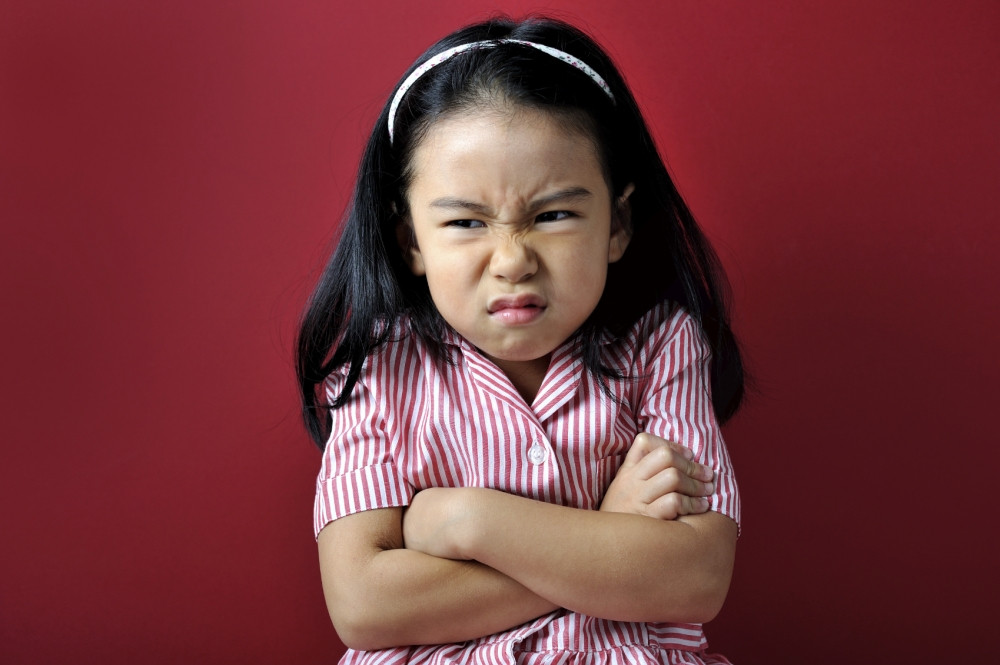

facial_expression_model_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facial_expression_model_weights.h5
To: /root/.deepface/weights/facial_expression_model_weights.h5
100%|██████████| 5.98M/5.98M [00:00<00:00, 24.4MB/s]


age_model_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/age_model_weights.h5
To: /root/.deepface/weights/age_model_weights.h5
100%|██████████| 539M/539M [01:00<00:00, 8.83MB/s]


gender_model_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/gender_model_weights.h5
To: /root/.deepface/weights/gender_model_weights.h5
100%|██████████| 537M/537M [01:14<00:00, 7.26MB/s]


race_model_single_batch.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/race_model_single_batch.h5
To: /root/.deepface/weights/race_model_single_batch.h5
100%|██████████| 537M/537M [01:32<00:00, 5.80MB/s]
Action: emotion:   0%|          | 0/4 [00:00<?, ?it/s]

1/1 [==============================] - 0s 490ms/step


Action: age:  25%|██▌       | 1/4 [00:01<00:03,  1.04s/it]    

1/1 [==============================] - 1s 785ms/step


Action: gender:  50%|█████     | 2/4 [00:02<00:02,  1.09s/it]

1/1 [==============================] - 1s 824ms/step


Action: race:  75%|███████▌  | 3/4 [00:03<00:00,  1.00it/s]  

1/1 [==============================] - 1s 810ms/step


Action: race: 100%|██████████| 4/4 [00:03<00:00,  1.02it/s]


In [ ]:
cv2_imshow(img)
faceAnalysis = DeepFace.analyze(img)

In [ ]:
# Analyze 
emotionAnalysis = faceAnalysis["emotion"]
print(emotionAnalysis)
print()
dominantEmotion = faceAnalysis["dominant_emotion"]
print(dominantEmotion)

{'angry': 90.91743230819702, 'disgust': 8.990591019392014, 'fear': 0.0864378409460187, 'happy': 1.455799214511444e-06, 'sad': 0.004550753146759234, 'surprise': 0.00048098199840751477, 'neutral': 0.0005088687430543359}

angry


Step 02: Connect to Spotify web developer account 

In [ ]:
cid = "89c71e3fd3544f5c852ce54f5d0b832e"
secret = "6e41df6f2e564086a0ce85d7616f1316"


In [ ]:
client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

Step 03: Fetch tracks and create dataframe from gathered track data

In [ ]:
artistName = []
trackName = []
trackId = []
year = []

# Collect songs from API
for i in range(0,1000,50):
    # Fetch 2015 tracks from API
    track_results = sp.search(q='year:2015', type='track', limit=50,offset=i)
    for i, t in enumerate(track_results['tracks']['items']):
        artistName.append(t['artists'][0]['name'])
        trackName.append(t['name'])
        trackId.append(t['id'])
        year.append('2015')
    # Fetch 2016 tracks from API
    track_results = sp.search(q='year:2016', type='track', limit=50,offset=i)
    for i, t in enumerate(track_results['tracks']['items']):
        artistName.append(t['artists'][0]['name'])
        trackName.append(t['name'])
        trackId.append(t['id'])
        year.append('2016')
    # Fetch 2017 tracks from API
    track_results = sp.search(q='year:2017', type='track', limit=50,offset=i)
    for i, t in enumerate(track_results['tracks']['items']):
        artistName.append(t['artists'][0]['name'])
        trackName.append(t['name'])
        trackId.append(t['id'])
        year.append('2017')
    # Fetch 2018 tracks from API
    track_results = sp.search(q='year:2018', type='track', limit=50,offset=i)
    for i, t in enumerate(track_results['tracks']['items']):
        artistName.append(t['artists'][0]['name'])
        trackName.append(t['name'])
        trackId.append(t['id'])
        year.append('2018')
    # Fetch 2019 tracks from API
    track_results = sp.search(q='year:2019', type='track', limit=50,offset=i)
    for i, t in enumerate(track_results['tracks']['items']):
        artistName.append(t['artists'][0]['name'])
        trackName.append(t['name'])
        trackId.append(t['id'])
        year.append('2019')
    # Fetch 2020 tracks from API
    track_results = sp.search(q='year:2020', type='track', limit=50,offset=i)
    for i, t in enumerate(track_results['tracks']['items']):
        artistName.append(t['artists'][0]['name'])
        trackName.append(t['name'])
        trackId.append(t['id'])
        year.append('2020')
    # Fetch 2021 tracks from API
    track_results = sp.search(q='year:2021', type='track', limit=50,offset=i)
    for i, t in enumerate(track_results['tracks']['items']):
        artistName.append(t['artists'][0]['name'])
        trackName.append(t['name'])
        trackId.append(t['id'])
        year.append('2021')
    # Fetch 2022 tracks from API
    track_results = sp.search(q='year:2022', type='track', limit=50,offset=i)
    for i, t in enumerate(track_results['tracks']['items']):
        artistName.append(t['artists'][0]['name'])
        trackName.append(t['name'])
        trackId.append(t['id'])
        year.append('2022')

print('number of elements in the track list:', len(trackId))

number of elements in the track list: 8000


In [ ]:
# Combine the artistName, trackName, and trackId lists to create a dataset
tracksDataset = pd.DataFrame({'artist_name':artistName,'track_name':trackName,'track_id':trackId, 'year':year})
print(tracksDataset.shape)
tracksDataset.head(20)

(8000, 4)


,artist_name,track_name,track_id,year
0,Beach House,Space Song,7H0ya83CMmgFcOhw0UB6ow,2015
1,The Weeknd,The Hills,7fBv7CLKzipRk6EC6TWHOB,2015
2,Bryson Tiller,Don't,3pXF1nA74528Edde4of9CC,2015
3,Lil Peep,Star Shopping,6Ox1rvlwEpB49drasQm6RF,2015
4,Chris Stapleton,Tennessee Whiskey,3fqwjXwUGN6vbzIwvyFMhx,2015
5,Lord Huron,The Night We Met,0QZ5yyl6B6utIWkxeBDxQN,2015
6,The Neighbourhood,Daddy Issues,5E30LdtzQTGqRvNd7l6kG5,2015
7,Vundabar,Alien Blues,11iIikXxC6NP0Ma8vMD27x,2015
8,Tame Impala,The Less I Know The Better,6K4t31amVTZDgR3sKmwUJJ,2015
9,$uicideboy$,Kill Yourself (Part III),0kEZlJh4mK1QRfb3CT5LPk,2015


In [ ]:
# Rename columns in the dataset
tracksDataset.rename(columns={'artist_name': 'artistName'}, inplace=True)
tracksDataset.rename(columns={'track_name': 'trackName'}, inplace=True)
tracksDataset.rename(columns={'track_id': 'trackId'}, inplace=True)
tracksDataset

,artistName,trackName,trackId,year
0,Beach House,Space Song,7H0ya83CMmgFcOhw0UB6ow,2015
1,The Weeknd,The Hills,7fBv7CLKzipRk6EC6TWHOB,2015
2,Bryson Tiller,Don't,3pXF1nA74528Edde4of9CC,2015
3,Lil Peep,Star Shopping,6Ox1rvlwEpB49drasQm6RF,2015
4,Chris Stapleton,Tennessee Whiskey,3fqwjXwUGN6vbzIwvyFMhx,2015
...,...,...,...,...
7995,Morgan Wallen,Tennessee Fan,3Ga7Uele3zN57vQ4F0HPTW,2022
7996,Taylor Swift,Sweet Nothing,3zmwONxswBAzGwExPugSLN,2022
7997,Lil Nas X,STAR WALKIN' (League of Legends Worlds Anthem),38T0tPVZHcPZyhtOcCP7pF,2022
7998,KAROL G,PROVENZA,7dSZ6zGTQx66c2GF91xCrb,2022


In [ ]:
# Drop duplicate tracks 
tracksDataset.drop_duplicates(subset=['artistName', 'trackName', 'year'], keep='first', inplace=True)

In [ ]:
# Sort dataset after dropping duplicates and count duplicates to check if drop was successful
newSortedData = tracksDataset.groupby(['artistName','trackName', 'trackId'], as_index=True).size()
newSortedData[newSortedData > 1].count()

0

In [ ]:
# Check size of the new dataframe
tracksDataset.shape

(1275, 4)

Step 04: Create dataframe for tracks with their relevant audio features

In [ ]:
# empty list, batchsize and the counter for None results  ####################
listWithAudioFeat = []
batchsize = 50
count = 0

for i in range(0, len(tracksDataset['trackId']), batchsize):
    batch = tracksDataset['trackId'][i:i+batchsize]
    results = sp.audio_features(batch)
    for i, a in enumerate(results):
        if a == None:
            count += 1
        else:
            listWithAudioFeat.append(a)
            
print('Count of songs with no available audio features:', count)

Count of songs with no available audio features: 1


In [ ]:
# Count number of songs with available audio features
print('Count of songs with readily available audio features:', len(listWithAudioFeat))

Count of songs with readily available audio features: 1274


In [ ]:
# Load track audio features and put into a new dataframe 
audioFeaturesData = pd.DataFrame.from_dict(listWithAudioFeat, orient='columns')
audioFeaturesData.head(5)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.508,0.792,0,-7.311,0,0.0297,0.2290,0.1240,0.1450,0.601,147.067,audio_features,7H0ya83CMmgFcOhw0UB6ow,spotify:track:7H0ya83CMmgFcOhw0UB6ow,https://api.spotify.com/v1/tracks/7H0ya83CMmgF...,https://api.spotify.com/v1/audio-analysis/7H0y...,320467,4
1,0.585,0.564,0,-7.063,0,0.0515,0.0671,0.0000,0.1350,0.137,113.003,audio_features,7fBv7CLKzipRk6EC6TWHOB,spotify:track:7fBv7CLKzipRk6EC6TWHOB,https://api.spotify.com/v1/tracks/7fBv7CLKzipR...,https://api.spotify.com/v1/audio-analysis/7fBv...,242253,4
2,0.765,0.356,11,-5.556,0,0.1950,0.2230,0.0000,0.0963,0.189,96.991,audio_features,3pXF1nA74528Edde4of9CC,spotify:track:3pXF1nA74528Edde4of9CC,https://api.spotify.com/v1/tracks/3pXF1nA74528...,https://api.spotify.com/v1/audio-analysis/3pXF...,198293,4
3,0.538,0.471,4,-9.840,0,0.0955,0.0946,0.0185,0.1160,0.307,93.070,audio_features,6Ox1rvlwEpB49drasQm6RF,spotify:track:6Ox1rvlwEpB49drasQm6RF,https://api.spotify.com/v1/tracks/6Ox1rvlwEpB4...,https://api.spotify.com/v1/audio-analysis/6Ox1...,142000,4
4,0.392,0.370,9,-10.888,1,0.0298,0.2050,0.0096,0.0821,0.512,48.718,audio_features,3fqwjXwUGN6vbzIwvyFMhx,spotify:track:3fqwjXwUGN6vbzIwvyFMhx,https://api.spotify.com/v1/tracks/3fqwjXwUGN6v...,https://api.spotify.com/v1/audio-analysis/3fqw...,293293,4


In [ ]:
# View the features/ attributes
audioFeaturesData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1274 entries, 0 to 1273
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      1274 non-null   float64
 1   energy            1274 non-null   float64
 2   key               1274 non-null   int64  
 3   loudness          1274 non-null   float64
 4   mode              1274 non-null   int64  
 5   speechiness       1274 non-null   float64
 6   acousticness      1274 non-null   float64
 7   instrumentalness  1274 non-null   float64
 8   liveness          1274 non-null   float64
 9   valence           1274 non-null   float64
 10  tempo             1274 non-null   float64
 11  type              1274 non-null   object 
 12  id                1274 non-null   object 
 13  uri               1274 non-null   object 
 14  track_href        1274 non-null   object 
 15  analysis_url      1274 non-null   object 
 16  duration_ms       1274 non-null   int64  


In [ ]:
# Drop irrelevant attributes
irrelevantCols = ['danceability', 'key', 'loudness', 'mode', 'speechiness', 
                  'acousticness', 'instrumentalness', 'liveness', 'tempo', 
                  'type',  'track_href', 'analysis_url', 'duration_ms', 'time_signature']
audioFeaturesData.drop(irrelevantCols, axis=1,inplace=True)

audioFeaturesData.rename(columns={'id': 'trackId'}, inplace=True)
audioFeaturesData.rename(columns={'energy': 'arousal'}, inplace=True)

audioFeaturesData.shape
audioFeaturesData

,arousal,valence,trackId,uri
0,0.792,0.601,7H0ya83CMmgFcOhw0UB6ow,spotify:track:7H0ya83CMmgFcOhw0UB6ow
1,0.564,0.137,7fBv7CLKzipRk6EC6TWHOB,spotify:track:7fBv7CLKzipRk6EC6TWHOB
2,0.356,0.189,3pXF1nA74528Edde4of9CC,spotify:track:3pXF1nA74528Edde4of9CC
3,0.471,0.307,6Ox1rvlwEpB49drasQm6RF,spotify:track:6Ox1rvlwEpB49drasQm6RF
4,0.370,0.512,3fqwjXwUGN6vbzIwvyFMhx,spotify:track:3fqwjXwUGN6vbzIwvyFMhx
...,...,...,...,...
1269,0.452,0.321,0KF5nzdiqZlxVK68MPITst,spotify:track:0KF5nzdiqZlxVK68MPITst
1270,0.906,0.792,5jJ69cMDMC0aeWPjZo6VP2,spotify:track:5jJ69cMDMC0aeWPjZo6VP2
1271,0.680,0.143,252T5dAokvMiNzXZchojoH,spotify:track:252T5dAokvMiNzXZchojoH
1272,0.896,0.745,75izAeHlGuOgA865CFDyIv,spotify:track:75izAeHlGuOgA865CFDyIv


In [ ]:
# Merge the both dataframes into one dataframe using only songs that appear in both
completeData = pd.merge(tracksDataset, audioFeaturesData, on='trackId', how='inner')
print("Shape of the dataset:", audioFeaturesData.shape)
completeData.head(5)

Shape of the dataset: (1274, 4)


,artistName,trackName,trackId,year,arousal,valence,uri
0,Beach House,Space Song,7H0ya83CMmgFcOhw0UB6ow,2015,0.792,0.601,spotify:track:7H0ya83CMmgFcOhw0UB6ow
1,The Weeknd,The Hills,7fBv7CLKzipRk6EC6TWHOB,2015,0.564,0.137,spotify:track:7fBv7CLKzipRk6EC6TWHOB
2,Bryson Tiller,Don't,3pXF1nA74528Edde4of9CC,2015,0.356,0.189,spotify:track:3pXF1nA74528Edde4of9CC
3,Lil Peep,Star Shopping,6Ox1rvlwEpB49drasQm6RF,2015,0.471,0.307,spotify:track:6Ox1rvlwEpB49drasQm6RF
4,Chris Stapleton,Tennessee Whiskey,3fqwjXwUGN6vbzIwvyFMhx,2015,0.370,0.512,spotify:track:3fqwjXwUGN6vbzIwvyFMhx


In [ ]:
# Create new column for emotions in the dataframe by 
# computing emotion for each track based on valence and arousal scores
def extract_value(row):
    if (0 <= row['valence'] <= 0.5) and (0 <= row['arousal'] <= 0.5):
        return "sad"
    elif (0 <= row['valence'] <= 0.5) and (0.5 <= row['arousal'] < 1):
        return "angry"
    elif (0.5 <= row['valence'] <= 1) and (0 <= row['arousal'] <= 0.5):
        return "calm"
    elif (0.5 <= row['valence'] <= 1) and (0.5 <= row['arousal'] <= 1):
        return "happy"


completeData['emotion'] = completeData.apply(extract_value, axis=1)

print(completeData.head(5))

# Get count of songs with each emotion to see the relevance of the emotion
print()
print("Count of sad songs = ", completeData['emotion'].value_counts()['sad'])
print("Count of angry songs = ", completeData['emotion'].value_counts()['angry'])
print("Count of calm songs = ", completeData['emotion'].value_counts()['calm'])
print("Count of happy songs = ", completeData['emotion'].value_counts()['happy'])

        artistName          trackName                 trackId  year  arousal  \
0      Beach House         Space Song  7H0ya83CMmgFcOhw0UB6ow  2015    0.792   
1       The Weeknd          The Hills  7fBv7CLKzipRk6EC6TWHOB  2015    0.564   
2    Bryson Tiller              Don't  3pXF1nA74528Edde4of9CC  2015    0.356   
3         Lil Peep      Star Shopping  6Ox1rvlwEpB49drasQm6RF  2015    0.471   
4  Chris Stapleton  Tennessee Whiskey  3fqwjXwUGN6vbzIwvyFMhx  2015    0.370   

   valence                                   uri emotion  
0    0.601  spotify:track:7H0ya83CMmgFcOhw0UB6ow   happy  
1    0.137  spotify:track:7fBv7CLKzipRk6EC6TWHOB   angry  
2    0.189  spotify:track:3pXF1nA74528Edde4of9CC     sad  
3    0.307  spotify:track:6Ox1rvlwEpB49drasQm6RF     sad  
4    0.512  spotify:track:3fqwjXwUGN6vbzIwvyFMhx    calm  

Count of sad songs =  304
Count of angry songs =  459
Count of calm songs =  72
Count of happy songs =  439


In [ ]:
# Assign numeric value to each emotion
def emoScore(row):
    if row['emotion'] == 'angry':
        return 0
    elif row['emotion'] == 'sad':
        return 1
    elif row['emotion'] == 'happy':
        return 2
    elif row['emotion'] == 'calm':
        return 3

completeData['emoScore'] = completeData.apply(emoScore, axis=1)

Step 05: Apply K-NN Classification on New Dataset to Group Songs

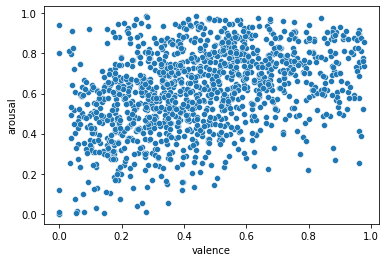

In [ ]:
# Visualize data using scatterplot
sns.scatterplot(x = 'valence', y = 'arousal', data = completeData)

In [ ]:
# Prepare the data for exploration
completeData[['valence', 'arousal']].describe().round(2)

,valence,arousal
count,1274.00,1274.00
mean,0.45,0.61
std,0.23,0.20
min,0.00,0.00
25%,0.27,0.47
50%,0.43,0.62
75%,0.60,0.76
max,0.98,0.98


In [ ]:
# Specify the dependent and independent variables from the dataset to be used
x = completeData[['valence', 'arousal']]
y = completeData['emoScore']

print(y)

0       2
1       0
2       1
3       1
4       3
       ..
1269    1
1270    2
1271    0
1272    2
1273    0
Name: emoScore, Length: 1274, dtype: int64


In [ ]:
# Split the data into training data and testing data
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.25)
print(X_test)

      valence  arousal
1012    0.496    0.478
573     0.457    0.253
397     0.515    0.378
1237    0.497    0.966
1255    0.646    0.704
...       ...      ...
508     0.570    0.641
579     0.311    0.482
1198    0.638    0.732
253     0.522    0.518
683     0.373    0.749

[319 rows x 2 columns]


In [ ]:
# Feature scale the data
from sklearn.preprocessing import StandardScaler   

featureScaler = StandardScaler()    
X_train = featureScaler.fit_transform(X_train)    
X_test = featureScaler.transform(X_test)  
print(X_train)

[[ 1.52754674  0.00870997]
 [ 0.09382324 -1.20758022]
 [-0.55864973 -0.87496208]
 ...
 [-1.17248943 -0.4678772 ]
 [-0.55435714  0.65408844]
 [ 1.25282128 -0.44305495]]


In [ ]:
# Fit the K-NN classifier to the training data
from sklearn.neighbors import KNeighborsClassifier

knnclassifier = KNeighborsClassifier(n_neighbors=4, metric='euclidean', p=2)

knnclassifier.fit(X_train, Y_train)

KNeighborsClassifier(metric='euclidean', n_neighbors=4)

In [ ]:
# Perform a prediction of the test results
Y_predictions = knnclassifier.predict(X_test)
print(Y_predictions)

[1 1 3 0 2 2 1 0 2 2 0 0 0 1 1 0 2 1 2 2 1 1 1 0 0 0 0 0 0 0 0 0 2 2 1 0 2
 0 1 1 1 2 1 2 2 1 0 1 0 0 0 2 2 2 2 0 1 3 1 0 1 2 0 2 0 0 2 2 0 0 1 3 0 1
 1 1 2 2 2 0 3 1 2 1 0 1 0 0 1 1 2 1 3 1 2 1 0 0 1 1 1 0 1 1 0 3 2 0 0 0 0
 1 0 1 0 0 0 2 2 2 1 2 1 0 0 1 2 2 0 2 0 2 3 1 1 2 2 0 0 0 1 2 0 0 1 0 2 0
 0 0 2 2 2 1 1 0 1 2 0 2 1 1 2 0 2 2 1 0 2 1 0 0 2 2 0 0 0 0 2 1 1 2 0 1 0
 2 2 0 2 0 2 0 0 1 2 0 0 3 0 0 1 0 2 1 2 0 0 3 0 0 0 0 1 2 0 1 1 1 0 3 2 1
 2 0 1 1 0 1 2 3 0 0 2 1 2 2 0 0 2 1 2 1 2 1 0 0 2 0 2 2 1 1 0 0 2 2 2 1 0
 1 2 1 3 2 0 1 1 2 2 3 0 1 1 0 0 1 2 2 2 0 2 1 0 1 1 3 2 1 0 2 0 1 1 2 2 1
 2 1 0 0 0 3 0 1 0 0 2 0 1 2 1 2 0 2 2 1 2 2 0]


In [ ]:
# Check the accuracy of the model using a confusion  matrix
from sklearn.metrics import confusion_matrix

confusionMatrix = confusion_matrix(Y_test, Y_predictions)
print(confusionMatrix)

[[112   0   0   0]
 [  3  90   0   0]
 [  1   0  95   0]
 [  0   2   1  15]]


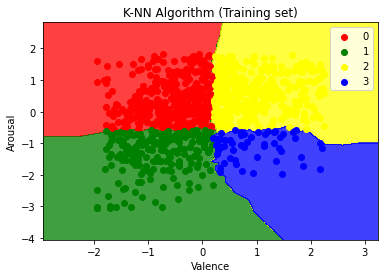

In [ ]:
# Visualize training set
from matplotlib.colors import ListedColormap ############

X_set, Y_set = X_train, Y_train
x1, x2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1,
                                stop = X_set[:, 0].max() + 1,
                                step = 0.01), 
                                np.arange(X_set[:, 1].min() - 1,
                                stop = X_set[:, 1].max() + 1,
                                step = 0.01))

plt.contourf(x1, x2, knnclassifier.predict(np.array([x1.ravel(), x2.ravel()]).T).reshape(x1.shape), 
             alpha = 0.75, cmap = ListedColormap(('red', 'green', 'yellow', 'blue')))
plt.xlim(x1.min(), x1.max())
plt.ylim(x2.min(), x2.max())

for i, j in enumerate(np.unique(Y_set)):  
    plt.scatter(X_set[Y_set == j, 0], X_set[Y_set == j, 1],  
        c = ListedColormap(('red', 'green', 'yellow', 'blue'))(i), label = j)  
plt.title('K-NN Algorithm (Training set)')  
plt.xlabel('Valence')  
plt.ylabel('Arousal')  
plt.legend()  
plt.show()  

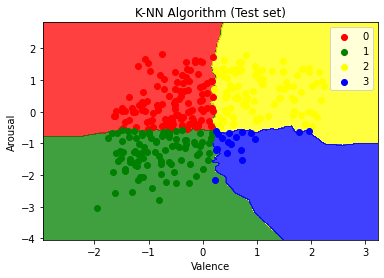

In [ ]:
# Visualize test results
from matplotlib.colors import ListedColormap ############

X_set, Y_set = X_test, Y_test
x1, x2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1,
                                stop = X_set[:, 0].max() + 1,
                                step = 0.01), 
                                np.arange(X_set[:, 1].min() - 1,
                                stop = X_set[:, 1].max() + 1,
                                step = 0.01))

plt.contourf(x1, x2, knnclassifier.predict(np.array([x1.ravel(), x2.ravel()]).T).reshape(x1.shape), 
             alpha = 0.75, cmap = ListedColormap(('red', 'green', 'yellow', 'blue')))
plt.xlim(x1.min(), x1.max())
plt.ylim(x2.min(), x2.max())

for i, j in enumerate(np.unique(Y_set)):  
    plt.scatter(X_set[Y_set == j, 0], X_set[Y_set == j, 1],  
        c = ListedColormap(('red', 'green', 'yellow', 'blue'))(i), label = j)  
plt.title('K-NN Algorithm (Test set)')  
plt.xlabel('Valence')  
plt.ylabel('Arousal')  
plt.legend()  
plt.show()  

In [ ]:
# Print classification report to evaluate performance of the model
print(classification_report(Y_test, Y_predictions, labels=[0, 1, 2, 3])) 

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       112
           1       0.98      0.97      0.97        93
           2       0.99      0.99      0.99        96
           3       1.00      0.83      0.91        18

    accuracy                           0.98       319
   macro avg       0.98      0.95      0.96       319
weighted avg       0.98      0.98      0.98       319



Step 06: Recommend song corresponding with detected emotion from Deepface algorithm


In [ ]:
# Assign a valence and arousal score from given range of values for each mood from emotion detection algorithm 
def assignValArous(emotion):
  if (dominantEmotion == 'sad'):
    valence = random.uniform(0,0.5)
    arousal = random.uniform(0,0.5)
    return valence, arousal 
  elif (dominantEmotion == 'happy' or dominantEmotion == 'surprise'):
    valence = random.uniform(0.5,1)
    arousal = random.uniform(0.5,1)
    return valence, arousal
  elif (dominantEmotion == 'fear' or dominantEmotion == 'disgust' or dominantEmotion == 'angry'):
    valence = random.uniform(0,0.5)
    arousal = random.uniform(0.5,1)
    return valence, arousal
  elif (dominantEmotion == 'neutral'):
    valence = 0.5
    arousal = 0.5
    return valence, arousal
  else:
    return "Sorry, no emotion detected by deepface algorithm. Try again?"

    
val_arous_score = (assignValArous(dominantEmotion))
print(val_arous_score)

(0.057020754017721165, 0.5726059191829427)


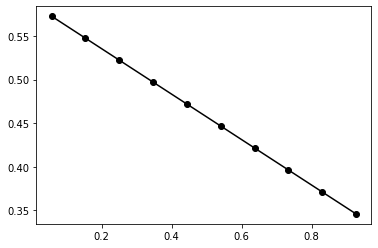

[(0.9272239438655359, 0.3460037842378827), (0.830534700549112, 0.37118179923177824), (0.7338454572326881, 0.3963598142256738), (0.6371562139162643, 0.4215378292195694), (0.5404669705998404, 0.4467158442134649), (0.4437777272834166, 0.4718938592073605), (0.34708848396699277, 0.49707187420125604), (0.25039924065056884, 0.5222498891951516), (0.15370999733414503, 0.5474279041890471), (0.057020754017721165, 0.5726059191829427)]


In [ ]:
# Plot a point to represent the desired state and a point to represent the current state
# Draw a line connecting the desired state to the current state and obtain 8 points on the line between the two states

def pointers(val_arous_score):
  if dominantEmotion == "sad":
    #goal emotion is happy
    happy_valence = random.uniform(0.5,1)
    happy_arousal = random.uniform(0.5,1)
    p1 = [happy_valence,happy_arousal]
    p2 = [val_arous_score[0], val_arous_score[1]]
    x_values = np.linspace(p1[0],p2[0],10)
    y_values = np.linspace(p1[1],p2[1],10)
    plt.plot(x_values,y_values,'-ok')
    plt.show()
    points = []
    for i in range(len(x_values)):
      point = (x_values[i],y_values[i])
      points.append(point)
    return points

  elif dominantEmotion == "fear" or dominantEmotion == "disgust" or dominantEmotion == "angry":
    #goal emotion is calm ?????????????????????
    calm_valence = random.uniform(0.5,1)
    calm_arousal = random.uniform(0.0,0.5)
    p1 = [calm_valence,calm_arousal]
    p2 = [val_arous_score[0], val_arous_score[1]]
    x_values = np.linspace(p1[0],p2[0],10)
    y_values = np.linspace(p1[1],p2[1],10)
    plt.plot(x_values,y_values,'-ok')
    plt.show()
    points = []
    for i in range(len(x_values)):
      point = (x_values[i],y_values[i])
      points.append(point)
    return points
    
  elif dominantEmotion == "neutral":

    calm_valence = random.uniform(0.5,1)
    calm_arousal = random.uniform(0.0,0.5)
    p1 = [calm_valence,calm_arousal]
    p2 = [val_arous_score[0], val_arous_score[1]]
    x_values = np.linspace(p2[0],p1[0],10)
    y_values = np.linspace(p2[1],p1[1],10)
    plt.plot(x_values,y_values,'-ok')
    plt.show()
    points = []
    for i in range(len(x_values)):
      point = (x_values[i],y_values[i])
      points.append(point)
    return points  

  elif dominantEmotion == "happy" or dominantEmotion == "surprise":
    happy_valence = random.uniform(0.5,1)
    happy_arousal = random.uniform(0.5,1)
    p1 = [happy_valence,happy_arousal]
    p2 = [val_arous_score[0], val_arous_score[1]]
    x_values = np.linspace(p1[0],p2[0],10)
    y_values = np.linspace(p1[1],p2[1],10)
    plt.plot(x_values,y_values,'-ok')
    plt.show()
    points = []
    for i in range(len(x_values)):
      point = (x_values[i],y_values[i])
      points.append(point)
    return points


songPoints = pointers(val_arous_score)
print(songPoints)
  

In [ ]:
#Fetch nearest song to every point generated on the line and append to playlist
playlist = []
trackIDs = []
trackURIs = []

musicNames = completeData["trackName"].values
trackID = completeData["trackId"].values
trackURI = completeData["uri"].values

completeDatanums = completeData[['valence', 'arousal']].copy()

neigh = NearestNeighbors(n_neighbors = 1)
neigh.fit(completeDatanums)

for i in songPoints:
  music_index = neigh.kneighbors([[i[0],i[1]]])[1][0]
  playlist.append(musicNames[music_index])
  trackIDs.append(trackID[music_index])
  trackURIs.append(trackURI[music_index])

# Series of print statements to see if recommender works right
print(*playlist, sep = "\n")

['7s7KOxwTHHnVBmtphJKWRk']
['68Ijc4fPmT3P5BN6Vrl2s2']
['2kPpxNSgXRvu5yqkRLKJIu']
['0LpHC9mhPAQC98IjXZIrif']
['7s5VQqrjBtrBgZL4pEa46S']
['4skuEIloXWuxxgekKupkEH']
['5Ma3BlNVDtn3JiwMEafSaq']
['2Gyc6e2cLxA5hoX1NOvYnU']
['3j84U36KvLeXNDPv4t5pI8']
['3nAq2hCr1oWsIU54tS98pL']
['Nights Like These']
['The Adams Administration']
["Winter Wonderland / Don't Worry Be Happy (feat. Tori Kelly)"]
['The Election of 1800']
['Romantic Lover']
['Tu Falta De Querer']
['Single']
['Say It']
['Pure Water (with Migos)']
['Waves']
10
False


Step 07: Reconnect to Spotify API and use IDs of suggested songs to create a playlist for the user. Add a link that the user can use to access the playlist

In [ ]:
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyOAuth
from spotipy.oauth2 import SpotifyClientCredentials
import json

cid = "89c71e3fd3544f5c852ce54f5d0b832e"
secret = "6e41df6f2e564086a0ce85d7616f1316"

scope = "playlist-modify-public"
username = "31i7tgnw7gbuwvcvuofpa5ifjgjy"

# Authenticate credentials of account being used for playlist creation
token = SpotifyOAuth(client_id = cid, client_secret = secret, scope=scope, username = username, redirect_uri="https://example.com/callback/")
spotify = spotipy.Spotify(oauth_manager = token)

playlist_name = input("Name of playlist: ")
playlist_description = input("Description of playlist: ")

# Create empty playlist
spotify.user_playlist_create(user=username, name=playlist_name, public=True, description=playlist_description)

# Get playlist id:
spotifyPlaylist = spotify.user_playlists(user=username)
playlistID = spotifyPlaylist['items'][0]['id']

trackIDs

# Add all songs from the recommended playlist array to the Spotify playlist
for i in trackIDs:
  spotify.user_playlist_add_tracks(username, playlistID, i)

print("Congratulations, playlist successfully created!")
print("Use the link below to access the profile and search their playlist library to find your new playlist.")
print("Link: https://open.spotify.com/user/31i7tgnw7gbuwvcvuofpa5ifjgjy?si=2affeb6cb26a40d5")

Name of playlist: one last time 
Description of playlist: hm
Congratulations, playlist successfully created!
Use the link below to access the profile and search their playlist library to find your new playlist
Link: https://open.spotify.com/user/31i7tgnw7gbuwvcvuofpa5ifjgjy?si=2affeb6cb26a40d5
